In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import warnings
#warnings.filterwarnings("ignore")

from pandas import Series

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import auc, roc_auc_score, roc_curve

import matplotlib.font_manager
from scipy import stats

/kaggle/input/bankscoring/sample_submission.csv
/kaggle/input/bankscoring/train.csv
/kaggle/input/bankscoring/test.csv


In [3]:
DATA_DIR = '/kaggle/input/bankscoring/'
train = pd.read_csv(DATA_DIR+'train.csv')
test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

Описания полей

    client_id - идентификатор клиента

    education - уровень образования

    sex - пол заемщика

    age - возраст заемщика

    car - флаг наличия автомобиля

    car_type - флаг автомобиля иномарки

    decline_app_cnt - количество отказанных прошлых заявок

    good_work - флаг наличия “хорошей” работы

    bki_request_cnt - количество запросов в БКИ

    home_address - категоризатор домашнего адреса

    work_address - категоризатор рабочего адреса

    income - доход заемщика

    foreign_passport - наличие загранпаспорта

    sna - связь заемщика с клиентами банка

    first_time - давность наличия информации о заемщике

    score_bki - скоринговый балл по данным из БКИ

    region_rating - рейтинг региона

    app_date - дата подачи заявки

    default - флаг дефолта по кредиту


In [44]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [45]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [4]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['default'] = 0 # в тесте у нас нет значения default, мы его должны предсказать, по этому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем

Сделаем модель ничего не меняя, чтобы знать какая модель будет без каких-либо предобработок.

In [162]:
X = data.dropna().drop(['client_id', 'app_date', 'education', 'default', 'sample'], axis=1)
y = data.dropna()['default']

label_encoder = LabelEncoder()
for column in X[['sex', 'car', 'car_type', 'good_work', 'foreign_passport']]:
    X[column] = label_encoder.fit_transform(X[column])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 5)

model = RandomForestRegressor(n_estimators=200, random_state=5)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=5)

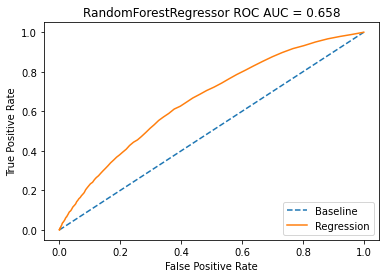

In [163]:
y_pred = model.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('RandomForestRegressor ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Если ничего не делать, то результат будет ROC AUC = 0.658. Значит нам нужно добиться лучшего результата.

In [49]:
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,0
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,0
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,0
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,0
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,0


Начнем с предобработки даты. Видим, что вид у неё формата DD{МЕС}YYYY. Переведем дату в удобный формат YYYYMMDD. Но сначала изучим какие есть вообще варианты даты.

In [50]:
# определяем уникальные годы
data['app_date'].apply(lambda x: x[5:]).unique()

array(['2014'], dtype=object)

Только 2014. Интересно. А какие месяцы?

In [51]:
data['app_date'].apply(lambda x: x[2:5]).unique()

array(['MAR', 'JAN', 'FEB', 'APR'], dtype=object)

Всего 4 месяца. Теперь можно сделать наше преобразование. Фактически мы сделаем численный признак. Чем позже дата, тем больше число. Возможно это как-то повлияет на модель.

In [52]:
t1_data = data.copy(deep=True) # делаем копию перед серьезными изменениями

In [53]:
# у нас всего один год и четыре уникальных месяца, но мы должны написать такой код, 
#что любые даты в формате датасета могли быть верно преобразованны

dict_date = {'JAN':'01','FEB':'02','MAR':'03','APR':'04','MAY':'05','JUN':'06',\
             'JUL':'07','AVG':'08','SEP':'09','OCT':'10','NOV':'11','DEC':'12'}
iterator = 0
for x in t1_data['app_date']:
    t1_data['app_date'][iterator] = int(str(t1_data['app_date'][iterator][5:9]) + \
                                        str(dict_date[t1_data['app_date'][iterator][2:5]]) + \
                                        str(t1_data['app_date'][iterator][0:2]))    
    iterator += 1
    
# а теперь переведем наши даты из восьмизначных к трезначным - так чтобы дни шли от единицы и дальше
# создаем словарь дата - число
iterator = 0
dict_day = {}
for i in np.sort(t1_data['app_date'].unique()):
    dict_day.setdefault(i, iterator+1)
    iterator += 1

# применяем данные к столбцу
iterator = 0
for x in t1_data['app_date']:    
    t1_data['app_date'][iterator] = dict_day[t1_data['app_date'][iterator]]
    iterator += 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [54]:
# проверяем удалось ли заменить дату последовательными числами от 1 и дальше
np.sort(t1_data['app_date'].unique())

array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
       71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87,
       88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120], dtype=object)

Проверяем улучшает или ухудшает дата в таком виде нашу модель.


In [160]:
X = t1_data.dropna().drop(['education', 'default', 'sample'], axis=1)
y = t1_data.dropna()['default']

label_encoder = LabelEncoder()
for column in X[['sex', 'car', 'car_type', 'good_work', 'foreign_passport']]:
    X[column] = label_encoder.fit_transform(X[column])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 5)

model = RandomForestRegressor(n_estimators=200, random_state=5)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=5)

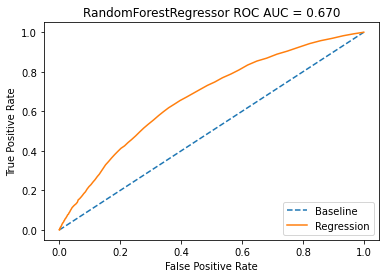

In [161]:
y_pred = model.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('RandomForestRegressor ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Стало лучше! Более, чем на процент лучше. Значит оставляем дату и переходим к другим признакам.

In [57]:
# проверяем есть ли в базе более одной записи по одному и тому же клиенту
t1_data['client_id'].value_counts().max()

1

Раз все записи это уникальные клиенты - показатель client_id не несет для нас никакой ценности. Удаляем его.

In [58]:
t1_data = t1_data.drop(['client_id'], axis=1)

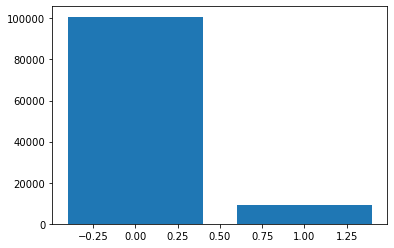

In [59]:
# проверяем соотношение клиентов с дефолтом к клиентам без дефолта в прошлом
default_yes = len(t1_data[t1_data['default'] == 1])
default_no = len(t1_data[t1_data['default'] == 0])

index = [0,1]
values = [default_no,default_yes]
plt.bar(index,values)
plt.show()

Большинство клиентов не имели дефолтов в прошлом.

In [60]:
# Смотрим количество пропусков в столбцах
for col in t1_data.columns:
    pct_missing = np.sum(t1_data[col].isnull())
    print('{} - {}'.format(col, pct_missing))

app_date - 0
education - 478
sex - 0
age - 0
car - 0
car_type - 0
decline_app_cnt - 0
good_work - 0
score_bki - 0
bki_request_cnt - 0
region_rating - 0
home_address - 0
work_address - 0
income - 0
sna - 0
first_time - 0
foreign_passport - 0
sample - 0
default - 0


Видим, что пропуски есть только в одном признаке - education, рассмотрим его подробнее.

<AxesSubplot:>

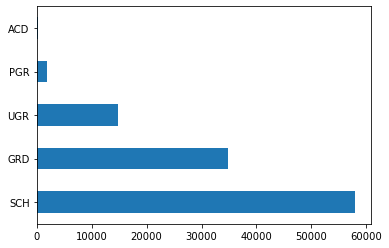

In [61]:
t1_data['education'].value_counts().plot.barh()

Поскольку пропусков очень мало - попробуем заменить строки с пропущенными значениями на самые популярные значения SCH и посмотрим как это отразится на модели.

In [62]:
t2_data = t1_data.copy(deep=True)

Переведем значение признака education в числовой.

In [63]:
t2_data['education'].value_counts().index

Index(['SCH', 'GRD', 'UGR', 'PGR', 'ACD'], dtype='object')

In [64]:
# переводим признак education в числовой и заполняем пропуски нолями, так как ноль соответствует самому популярному значению - SCH.
dct_education = {'SCH': 1, 'GRD': 2, 'UGR': 3, 'PGR': 4, 'ACD': 5}
t2_data['education'] = t2_data['education'].map(dct_education)
t2_data['education'] = t2_data['education'].fillna(1) # заполняем пропущенные занчения самым популярным значением SCH
t2_data.head()

,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,81,2.0,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,0
1,24,1.0,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,0
2,82,3.0,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,0
3,34,1.0,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,0
4,35,2.0,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,0


Пробуем удалить признак education, но оставляем ранее удаляемые в модели строки (где education был пустой).

In [65]:
X = t2_data.dropna().drop(['education', 'default', 'sample'], axis=1)
y = t2_data.dropna()['default']

label_encoder = LabelEncoder()
for column in X[['sex', 'car', 'car_type', 'good_work', 'foreign_passport']]:
    X[column] = label_encoder.fit_transform(X[column])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 5)

model = RandomForestRegressor(n_estimators=200, random_state=5)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=5)

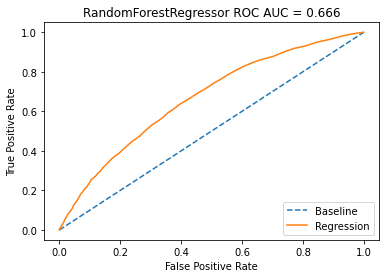

In [66]:
y_pred = model.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('RandomForestRegressor ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Получаем хуже результат. Значит оставлять те строки с пустым значение education не стоит.

In [67]:
t3_data = t1_data.dropna().copy(deep=True)

In [68]:
t3_data.isna().sum()

app_date            0
education           0
sex                 0
age                 0
car                 0
car_type            0
decline_app_cnt     0
good_work           0
score_bki           0
bki_request_cnt     0
region_rating       0
home_address        0
work_address        0
income              0
sna                 0
first_time          0
foreign_passport    0
sample              0
default             0
dtype: int64

In [69]:
X = t3_data.dropna().drop(['education', 'default', 'sample'], axis=1)
y = t3_data.dropna()['default']

label_encoder = LabelEncoder()
for column in X[['sex', 'car', 'car_type', 'good_work', 'foreign_passport']]:
    X[column] = label_encoder.fit_transform(X[column])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 5)

model = RandomForestRegressor(n_estimators=200, random_state=5)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=5)

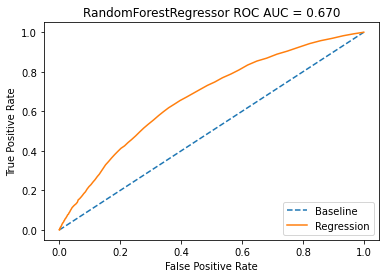

In [70]:
y_pred = model.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('RandomForestRegressor ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Вернулись на исходную точку. Теперь попробуем оставить признак education после его преобразований.

In [71]:
# переводим признак education в числовой и заполняем пропуски нолями, так как ноль соответствует самому популярному значению - SCH.
dct_education = {'SCH': 1, 'GRD': 2, 'UGR': 3, 'PGR': 4, 'ACD': 5}
t3_data['education'] = t3_data['education'].map(dct_education)
t3_data.head()

,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,81,2,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,0
1,24,1,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,0
2,82,3,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,0
3,34,1,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,0
4,35,2,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,0


In [72]:
X = t3_data.dropna().drop(['default', 'sample'], axis=1)
y = t3_data.dropna()['default']

label_encoder = LabelEncoder()
for column in X[['sex', 'car', 'car_type', 'good_work', 'foreign_passport']]:
    X[column] = label_encoder.fit_transform(X[column])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 5)

model = RandomForestRegressor(n_estimators=200, random_state=5)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=5)

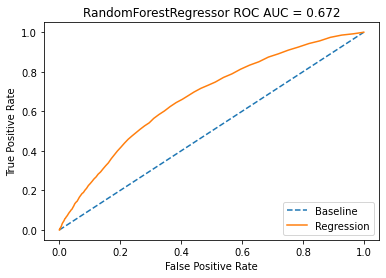

In [73]:
y_pred = model.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('RandomForestRegressor ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Поиграем теперь с полным удалением всех категориальных и бинарных признаков, кроме уже проверенных app_date и education. Их оставим так как знаем, что они улучшают модель. Также оставим только численные признаки. Будем добавлять и экспериментировать с самиыми важными признаками.

In [74]:
t4_data = t3_data.copy(deep=True)
t4_data = t4_data.dropna()

Для начала попробуем даммизировать признак education.

In [75]:
oe_style = OneHotEncoder()
oe_results = oe_style.fit_transform(t4_data[["education"]])
pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_).head()

,1,2,3,4,5
0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0


In [76]:
t4_data = t4_data.join(pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_))

In [77]:
t4_data = t4_data.dropna()

In [78]:
X = t4_data.dropna().drop(['education', 'default', 'sample'], axis=1)
y = t4_data.dropna()['default']

label_encoder = LabelEncoder()
for column in X[['sex', 'car', 'car_type', 'good_work', 'foreign_passport']]:
    X[column] = label_encoder.fit_transform(X[column])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 5)

model = RandomForestRegressor(n_estimators=200, random_state=5)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=5)

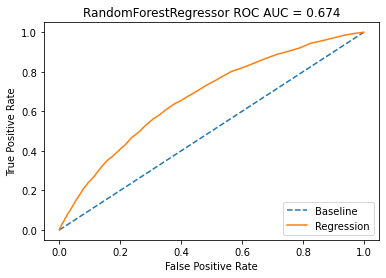

In [79]:
y_pred = model.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('RandomForestRegressor ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Ничего не поменялось, поэтому оставим его как есть. Теперь попробуем убрать все не чисельные признаки.

In [80]:
X = t3_data.dropna().drop(['sex', 'car', 'car_type', 'good_work', 'region_rating', 'home_address', 'work_address', \
                           'sna', 'first_time', 'foreign_passport', 'default', 'sample'], axis=1)
y = t3_data.dropna()['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 5)

model = RandomForestRegressor(n_estimators=200, random_state=5)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=5)

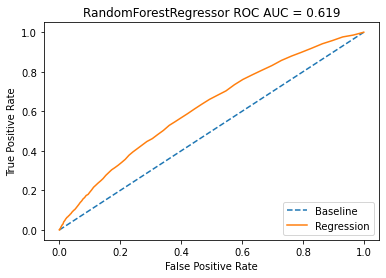

In [81]:
y_pred = model.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('RandomForestRegressor ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Модель сильно ухудшилась. Теперь будем пробовать изменять самые важные признаки.

Попробуем удалить только бинарные признаки.

In [82]:
X = t3_data.dropna().drop(['sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'default', 'sample'], axis=1)
y = t3_data.dropna()['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 5)

model = RandomForestRegressor(n_estimators=200, random_state=5)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=5)

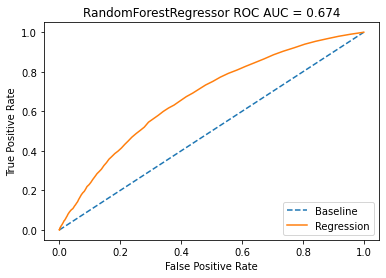

In [83]:
y_pred = model.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('RandomForestRegressor ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Стало немного лучше. Попробуем добавить даммизированные бинарные признаки.

In [84]:
t6_data = t3_data.copy(deep=True)

In [85]:
oe_style = OneHotEncoder()
oe_results = oe_style.fit_transform(t6_data[["sex"]])
t6_data = t6_data.join(pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_))

In [86]:
X = t6_data.dropna().drop(['sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'default', 'sample'], axis=1)
y = t6_data.dropna()['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 5)

model = RandomForestRegressor(n_estimators=200, random_state=5)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=5)

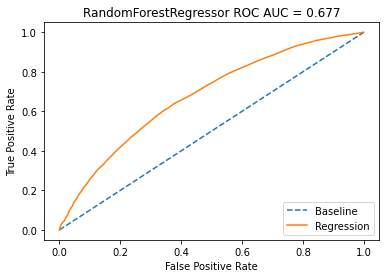

In [87]:
y_pred = model.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('RandomForestRegressor ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Стало еще немного лучше. Пробуем тоже саме с другими признаками.

In [88]:
t7_data = t6_data.copy(deep=True)

In [89]:
oe_style = OneHotEncoder()
oe_results = oe_style.fit_transform(t7_data[["car"]])
t7_data = t7_data.join(pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_))

In [90]:
X = t7_data.dropna().drop(['sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'default', 'sample'], axis=1)
y = t7_data.dropna()['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 5)

model = RandomForestRegressor(n_estimators=200, random_state=5)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=5)

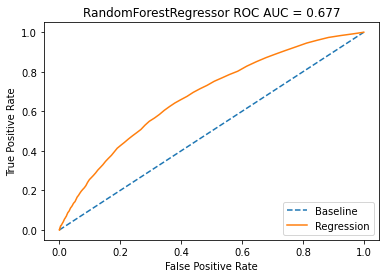

In [91]:
y_pred = model.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('RandomForestRegressor ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Никаких изменений. Удаляем этот признак полностью.

In [92]:
t8_data = t6_data.copy(deep=True)
t8_data = t8_data.drop(['car','sex'], axis=1)

In [93]:
oe_style = OneHotEncoder()
oe_results = oe_style.fit_transform(t8_data[["car_type"]])
t8_data = t8_data.join(pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_))

In [94]:
X = t8_data.dropna().drop(['car_type', 'good_work', 'foreign_passport', 'default', 'sample'], axis=1)
y = t8_data.dropna()['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 5)

model = RandomForestRegressor(n_estimators=200, random_state=5)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=5)

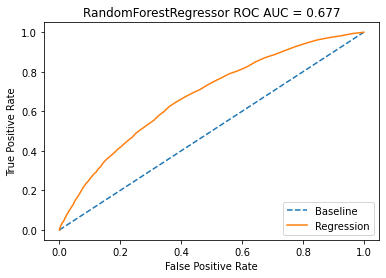

In [95]:
y_pred = model.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('RandomForestRegressor ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Никаких изменений, можно удалить car_type тоже.

In [96]:
t9_data = t6_data.copy(deep=True)
t9_data = t9_data.drop(['car','sex','car_type'], axis=1)

In [97]:
oe_style = OneHotEncoder()
oe_results = oe_style.fit_transform(t9_data[["good_work"]])
t9_data = t9_data.join(pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_))

In [98]:
X = t9_data.dropna().drop(['good_work', 'foreign_passport', 'default', 'sample'], axis=1)
y = t9_data.dropna()['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 5)

model = RandomForestRegressor(n_estimators=200, random_state=5)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=5)

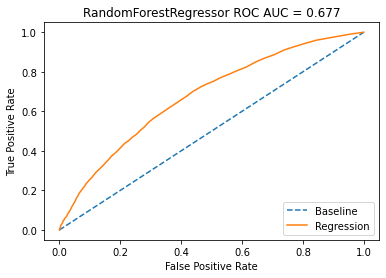

In [99]:
y_pred = model.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('RandomForestRegressor ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Опять никаких изменений. Можем удалить признак good_work.

Сгруппируем в три категории по типу их обработки (категориальные, бинарные и числовые).
Для дальнейшего удобного анализа.

In [100]:
bin_cols = ['sex','car','car_type','foreign_passport','good_work']
cat_cols = ['education','work_address','home_address', 'first_time', 'sna', 'region_rating']
num_cols = ['age','decline_app_cnt','income','bki_request_cnt', 'score_bki', 'app_date']

In [101]:
t10_data = t6_data.copy(deep=True)
t10_data = t10_data.drop(['car','sex','car_type', 'good_work'], axis=1)

In [102]:
oe_style = OneHotEncoder()
oe_results = oe_style.fit_transform(t10_data[["foreign_passport"]])
t10_data = t10_data.join(pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_))

In [103]:
X = t10_data.dropna().drop(['foreign_passport', 'default', 'sample'], axis=1)
y = t10_data.dropna()['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 5)

model = RandomForestRegressor(n_estimators=200, random_state=5)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=5)

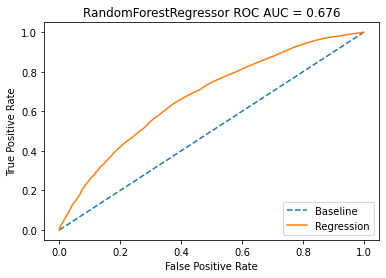

In [104]:
y_pred = model.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('RandomForestRegressor ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Результат ухудшился, поэтому удаляем тоже признак foreign_passport. Существенно сократив датасет двигаемся дальше. Тут либо мой подход не верный концептуально - либо большинство бинарних признаков бесполезны. По крайней мере в виде даммизированных признаков точно.

In [105]:
t11_data = t6_data.copy(deep=True)
t11_data = t11_data.drop(['car','sex','car_type', 'good_work', 'foreign_passport'], axis=1)

In [106]:
oe_style = OneHotEncoder()
oe_results = oe_style.fit_transform(t11_data[["region_rating"]])
t11_data = t11_data.join(pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_))

In [107]:
X = t11_data.dropna().drop(['region_rating', 'default', 'sample'], axis=1)
y = t11_data.dropna()['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 5)

model = RandomForestRegressor(n_estimators=200, random_state=5)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=5)

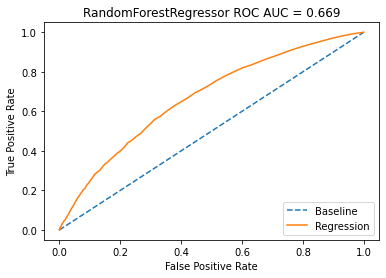

In [108]:
y_pred = model.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('RandomForestRegressor ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Результат заметно ухудшается, поэтому оставляем как есть.

In [109]:
t12_data = t6_data.copy(deep=True)
t12_data = t12_data.drop(['car','sex','car_type', 'good_work', 'foreign_passport'], axis=1)

In [110]:
oe_style = OneHotEncoder()
oe_results = oe_style.fit_transform(t12_data[["home_address"]])
t12_data = t12_data.join(pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_))

In [111]:
X = t12_data.dropna().drop(['home_address', 'default', 'sample'], axis=1)
y = t12_data.dropna()['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 5)

model = RandomForestRegressor(n_estimators=200, random_state=5)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=5)

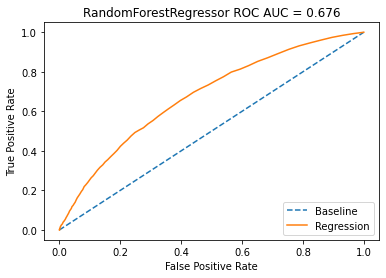

In [112]:
y_pred = model.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('RandomForestRegressor ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Никаких изменений, поэтому оставляем как есть.

In [113]:
t13_data = t6_data.copy(deep=True)
t13_data = t13_data.drop(['car','sex','car_type', 'good_work', 'foreign_passport'], axis=1)

In [114]:
oe_style = OneHotEncoder()
oe_results = oe_style.fit_transform(t13_data[["work_address"]])
t13_data = t13_data.join(pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_))

In [115]:
X = t13_data.dropna().drop(['work_address', 'default', 'sample'], axis=1)
y = t13_data.dropna()['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 5)

model = RandomForestRegressor(n_estimators=200, random_state=5)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=5)

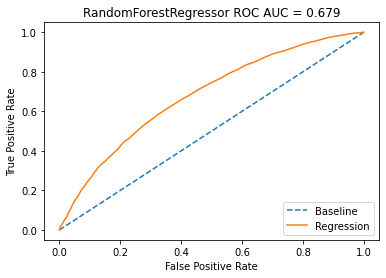

In [116]:
y_pred = model.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('RandomForestRegressor ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [117]:
t13_data = t13_data.rename(columns={t13_data.columns[16]:"work_address_1",t13_data.columns[17]:"work_address_2",t13_data.columns[18]:"work_address_3"})
t13_data = t13_data.drop(['work_address'], axis=1)

Есть улучшение, поэтому оставляем признак в даммизированном виде.

In [118]:
t14_data = t13_data.copy(deep=True)

In [119]:
oe_style = OneHotEncoder()
oe_results = oe_style.fit_transform(t14_data[["sna"]])
t14_data = t14_data.join(pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_))

In [120]:
X = t14_data.dropna().drop(['sna', 'default', 'sample'], axis=1)
y = t14_data.dropna()['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 5)

model = RandomForestRegressor(n_estimators=200, random_state=5)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=5)

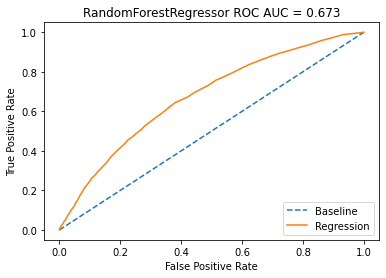

In [121]:
y_pred = model.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('RandomForestRegressor ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Результат ухудшается, поэтому оставим без изменений.

In [122]:
t15_data = t13_data.copy(deep=True)

In [123]:
oe_style = OneHotEncoder()
oe_results = oe_style.fit_transform(t15_data[["first_time"]])
t15_data = t15_data.join(pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_))

In [124]:
X = t15_data.dropna().drop(['first_time', 'default', 'sample'], axis=1)
y = t15_data.dropna()['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 5)

model = RandomForestRegressor(n_estimators=200, random_state=5)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=5)

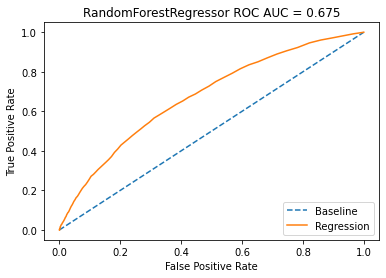

In [125]:
y_pred = model.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('RandomForestRegressor ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Тоже хуже, поэтому оставляем без изменений.

In [126]:
t16_data = t13_data.copy(deep=True)

Посмотрим как выглядит датасет после всех преобразований с категориальными и бинарными признаками.

In [127]:
t16_data.head(5)

,app_date,education,age,decline_app_cnt,score_bki,bki_request_cnt,region_rating,home_address,income,sna,first_time,sample,default,"(F,)","(M,)",work_address_1,work_address_2,work_address_3
0,81,2,29,0,-2.271884,3,50,1,50000,1,4,0,0,0.0,1.0,0.0,1.0,0.0
1,24,1,39,5,-1.504999,2,50,1,5000,4,3,0,0,1.0,0.0,0.0,1.0,0.0
2,82,3,50,0,-1.691339,1,50,1,30000,1,3,0,0,0.0,1.0,0.0,1.0,0.0
3,34,1,56,0,-2.374182,1,40,1,17000,1,3,0,0,0.0,1.0,0.0,1.0,0.0
4,35,2,38,0,-2.487502,0,80,2,120000,1,3,0,0,1.0,0.0,0.0,0.0,1.0


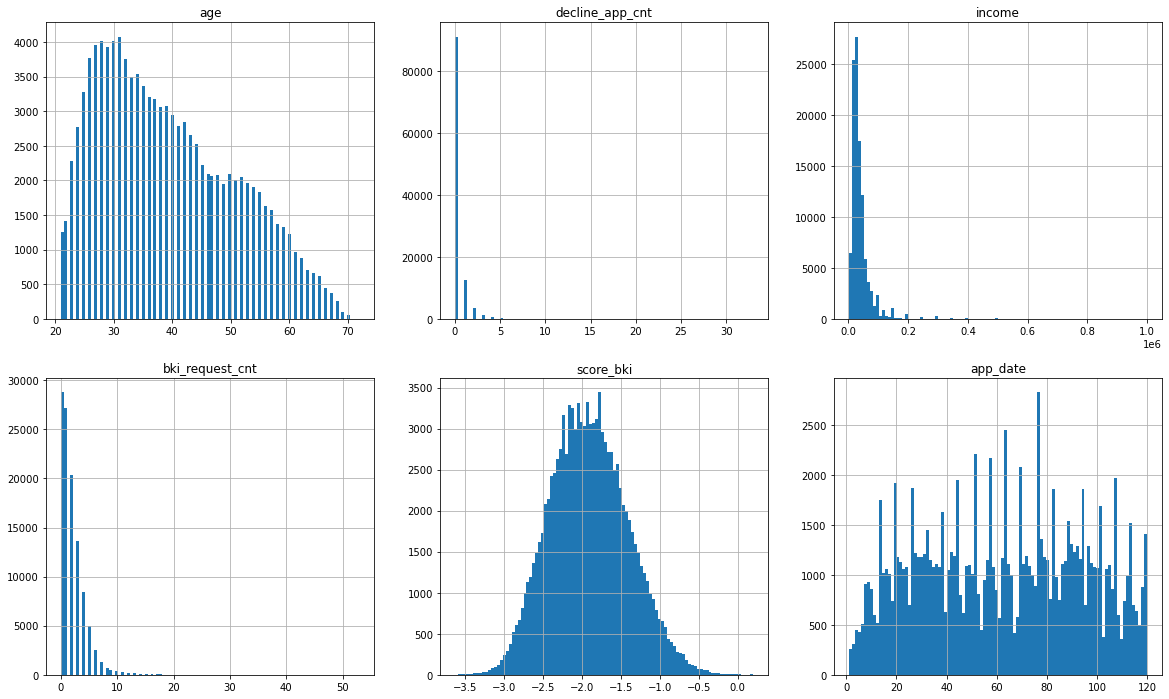

In [128]:
# посмотрим на распределение числовых данных
plt.figure(figsize=(20, 12))
iterator = 1
for i in num_cols:
    plt.subplot(2, 3, iterator)
    t16_data[i].hist(bins=100)
    plt.title(i)
    iterator += 1

Видим тяжелые правые хвосты. Пробуем логарифмировать, но помогает не сильно.

In [129]:
# возводим данный признак в квадрат, чтобы избавиться от отрицательных значений
t16_data['score_bki'] = t16_data['score_bki'] ** 2

Попробуем построить модель с квадратом score_bki

In [130]:
X = t16_data.dropna().drop([ 'default', 'sample'], axis=1)
y = t16_data.dropna()['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 5)

model = RandomForestRegressor(n_estimators=200, random_state=5)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=5)

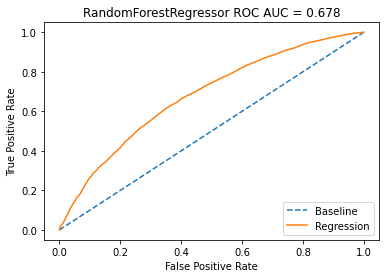

In [131]:
y_pred = model.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('RandomForestRegressor ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Результат чуть хуже, поэтому не будем так делать. Попробуем прологарифмировать признаки с тяжелыми хвостами.

In [132]:
t17_data = t13_data.copy(deep=True)

<AxesSubplot:>

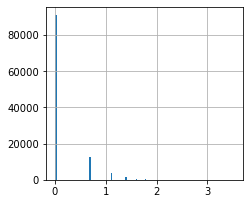

In [133]:
plt.figure(figsize=(12, 7))
plt.subplot(2, 3, 1)
(np.log(t17_data['decline_app_cnt']+1)).hist(bins=100)

<AxesSubplot:>

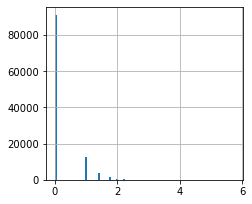

In [134]:
plt.figure(figsize=(12, 7))
plt.subplot(2, 3, 1)
(t17_data['decline_app_cnt']**0.5).hist(bins=100)

In [135]:
t17_data['decline_app_cnt'] = np.log(t17_data['decline_app_cnt']+1)
t17_data['decline_app_cnt'] = t17_data['decline_app_cnt']**0.5

In [136]:
X = t17_data.dropna().drop([ 'default', 'sample'], axis=1)
y = t17_data.dropna()['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 5)

model = RandomForestRegressor(n_estimators=200, random_state=5)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=5)

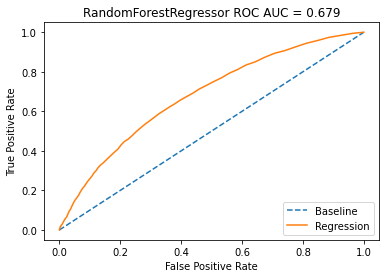

In [137]:
y_pred = model.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('RandomForestRegressor ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Логарифмирование и корень из decline_app_cnt никак не влияют на результат, поэтому оставим этот параметр как есть.

In [164]:
t18_data = t13_data.copy(deep=True)

<AxesSubplot:>

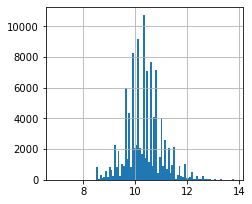

In [139]:
plt.figure(figsize=(12, 7))
plt.subplot(2, 3, 1)
(np.log(t18_data['income']+1)).hist(bins=100)

<AxesSubplot:>

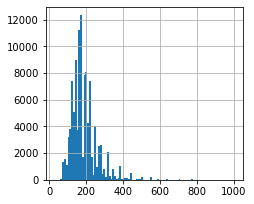

In [140]:
plt.figure(figsize=(12, 7))
plt.subplot(2, 3, 1)
(t18_data['income']**0.5).hist(bins=100)

In [165]:
t18_data['income'] = np.log(t17_data['income']+1)
#t18_data['income'] = t17_data['income']**0.5

In [142]:
X = t18_data.dropna().drop([ 'default', 'sample'], axis=1)
y = t18_data.dropna()['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 5)

model = RandomForestRegressor(n_estimators=200, random_state=5)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=5)

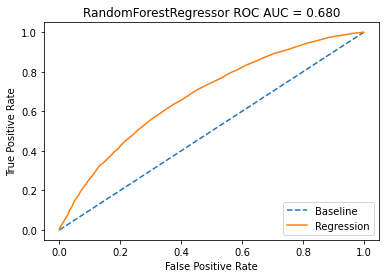

In [143]:
y_pred = model.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('RandomForestRegressor ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Логарифмирование признака income как визуально выравнивает, так и по цифрам улучшает показатель модели. Оставляем этот параметр логарифмированным.

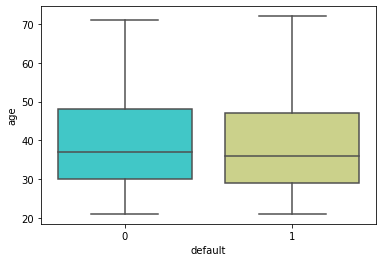

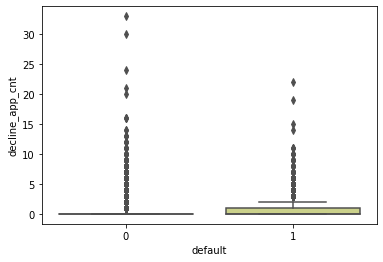

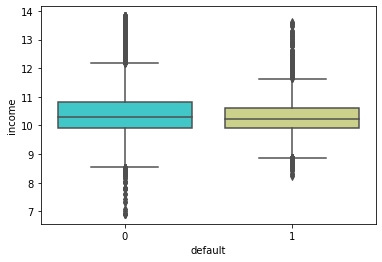

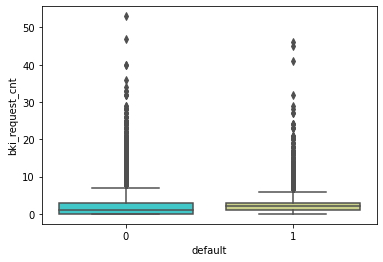

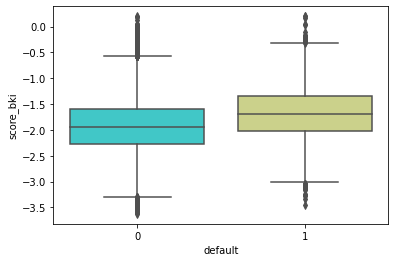

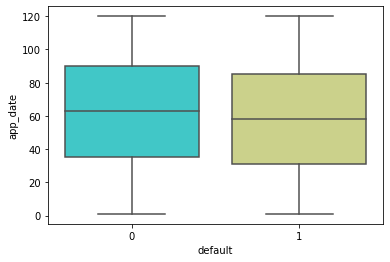

In [144]:
# смотрим зависимость дефолотов от численных переменных через boxplot’ы
for i in num_cols:
    sns.boxplot(x='default', y=i, data=t18_data, palette='rainbow');    
    plt.show()

Большинство признаков нельзя почистить от выбросов по модели 1,5 IQR так как их распределение имеет тяжелые хвосты.

<AxesSubplot:>

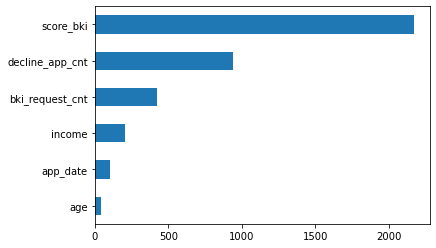

In [166]:
# построим визуализацию важности численных признаков с помощью функции f_classif из библиотеки sklearn
imp_num = Series(f_classif(t18_data[num_cols], t18_data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

<AxesSubplot:>

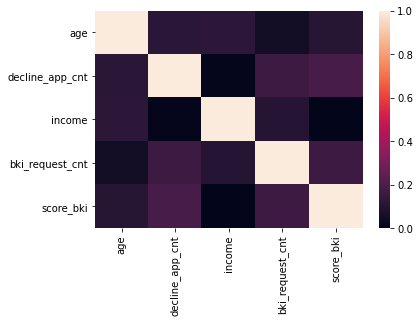

In [168]:
# оценим корреляцию Пирсона для непрерывных переменных
sns.heatmap(t18_data[num_cols].corr().abs(), vmin=0, vmax=1)

Учитывая, что score_bki достаточно важный параметр - корреляция с decline_app_cnt может быть негативна. Поэтому пробуем удалить decline_app_cnt и проверить модель. 

In [169]:
X = t18_data.dropna().drop(['decline_app_cnt', 'default', 'sample'], axis=1)
y = t18_data.dropna()['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 5)

model = RandomForestRegressor(n_estimators=200, random_state=5)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=5)

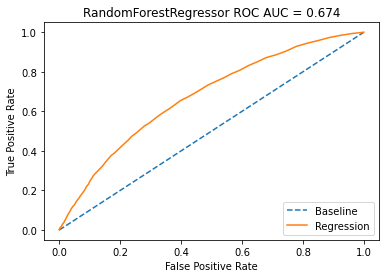

In [170]:
y_pred = model.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('RandomForestRegressor ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Результат ухудшился, поэтому вернем обратно decline_app_cnt и попробуем поиграть с преобразования показателя score_bki.

Возведение в квадрат не помогло, логарифм тоже. Поэтому оставим его как есть.

In [179]:
from sklearn.ensemble import ExtraTreesClassifier

X = t18_data.dropna().drop(['default', 'sample'], axis=1)
y = t18_data.dropna()['default']

model = ExtraTreesClassifier()
model.fit(X, y)
# display the relative importance of each attribute
pd.DataFrame(t18_data.drop(['default', 'sample'], axis=1).columns,model.feature_importances_).sort_index()

,0
0.149236,app_date
0.040953,education
0.142485,age
0.049644,decline_app_cnt
0.167965,score_bki
0.104769,bki_request_cnt
0.061018,region_rating
0.020872,home_address
0.140499,income
0.028718,sna


Поработаем с важными признаками.

In [ ]:
Наверняка может быть зависимость от дня недели. Попробуем из одного признака app_date сделать дамми-признак дни недели.

In [236]:
t19_data = t18_data.copy(deep=True)

In [240]:
t19_data['app_date0'] = 0
t19_data['app_date1'] = 0
t19_data['app_date2'] = 0
t19_data['app_date3'] = 0
t19_data['app_date4'] = 0
t19_data['app_date5'] = 0
t19_data['app_date6'] = 0
iterator = 0
for x in t19_data['app_date']:
    day = x % 7
    t19_data['app_date' + str(day)][iterator] = 1
    iterator += 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [242]:
X = t19_data.dropna().drop(['default', 'sample'], axis=1)
y = t19_data.dropna()['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 5)

model = RandomForestRegressor(n_estimators=200, random_state=5)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=5)

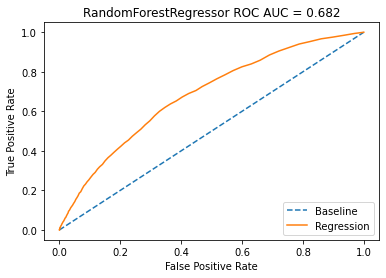

In [243]:
y_pred = model.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('RandomForestRegressor ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Стало чуть-чуть лучше. Оставляем эти признаки. Пробуем тоже само сделать с возрастом. В контекстной рекламе возраст четко разделяют на группы 18-24, 25-34, 35-44, 45-54, 55-64, 65+. Наверное они опираются на опыт разных поведенческих факторов и групп интересов для данных возрастных групп. Попробуем и мы этим знанием воспользоваться.

In [244]:
t20_data = t19_data.copy(deep=True)

In [246]:
# P.S. Знаю что код длинный, не красивый и можно гораздо короче, но очень устал за два дня работы над проектом 
# и уже нету времени и сил гуглить функции, которые помогут сделать красивее.

t20_data['age_18-24'] = 0
t20_data['age_25-34'] = 0
t20_data['age_35-44'] = 0
t20_data['age_45-54'] = 0
t20_data['age_55-64'] = 0
t20_data['age_65'] = 0
iterator = 0
for x in t20_data['age']:
    if 17 < x < 25:
        t20_data['age_18-24'][iterator] = 1
    elif 24 < x < 35:
        t20_data['age_25-34'][iterator] = 1
    elif 34 < x < 45:
        t20_data['age_35-44'][iterator] = 1
    elif 44 < x < 55:
        t20_data['age_45-54'][iterator] = 1
    elif 54 < x < 65:
        t20_data['age_55-64'][iterator] = 1
    elif 64 < x:
        t20_data['age_65'][iterator] = 1    
    iterator += 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: Settin

In [250]:
X = t20_data.dropna().drop(['default', 'sample'], axis=1)
y = t20_data.dropna()['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 5)

model = RandomForestRegressor(n_estimators=200, random_state=5)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=5)

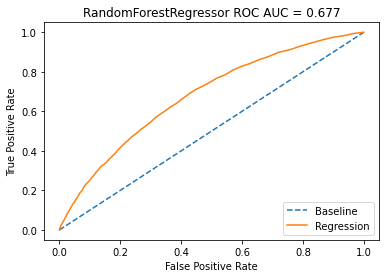

In [251]:
y_pred = model.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('RandomForestRegressor ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Стало чуть хуже, поэтому не будем использовать возрастную разбивку.

# Строим модель!

In [8]:
# выделяем тренировочный датасет из датасета data
data_train = data[data['sample'] == 1]
data_train = data_train.drop(['client_id', 'sample'], axis=1)

Пишем для удобства весь код в одном ячейке

In [9]:
# у нас всего один год и четыре уникальных месяца, но мы должны написать такой код, 
# что любые даты в формате датасета могли быть верно преобразованны

dict_date = {'JAN':'01','FEB':'02','MAR':'03','APR':'04','MAY':'05','JUN':'06',\
             'JUL':'07','AVG':'08','SEP':'09','OCT':'10','NOV':'11','DEC':'12'}
iterator = 0
for x in data_train['app_date']:
    data_train['app_date'].iloc[iterator] = int(str(data_train['app_date'].iloc[iterator][5:9]) \
                                           + str(dict_date[data_train['app_date'].iloc[iterator][2:5]]) \
                                           + str(data_train['app_date'].iloc[iterator][0:2]))
    iterator += 1
    
# а теперь переведем наши даты из восьмизначных к трезначным - так чтобы дни шли от единицы и дальше
# создаем словарь дата - число
iterator = 0
dict_day = {}
for i in np.sort(data_train['app_date'].unique()):
    dict_day.setdefault(i, iterator+1)
    iterator += 1

# применяем данные к столбцу
iterator = 0
for x in data_train['app_date']:    
    data_train['app_date'].iloc[iterator] = dict_day[data_train['app_date'].iloc[iterator]]
    iterator += 1

# переводим признак education в числовой и заполняем пропуски нолями, так как ноль соответствует самому популярному значению - SCH.
dct_education = {'SCH': 1, 'GRD': 2, 'UGR': 3, 'PGR': 4, 'ACD': 5}
data_train['education'] = data_train['education'].map(dct_education)
data_train['education'] = data_train['education'].fillna(1) # заполняем пропущенные занчения самым популярным значением SCH

# делаем дамми-признаки с признаком sex и work_address
oe_style = OneHotEncoder()
oe_results = oe_style.fit_transform(data_train[["sex"]])
data_train = data_train.join(pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_))

oe_style = OneHotEncoder()
oe_results = oe_style.fit_transform(data_train[["work_address"]])
data_train = data_train.join(pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_))

# удаляем не рабочие признаки и переименовуем для удобства столбцы
data_train = data_train.drop(['car','sex','car_type', 'good_work', 'foreign_passport', 'work_address'], axis=1)

# логарифмируем признак income
data_train['income'] = np.log(data_train['income']+1)

# создаем признаки - дни недели от признака app_date
data_train['app_date0'] = 0
data_train['app_date1'] = 0
data_train['app_date2'] = 0
data_train['app_date3'] = 0
data_train['app_date4'] = 0
data_train['app_date5'] = 0
data_train['app_date6'] = 0
iterator = 0
for x in data_train['app_date']:
    day = x % 7
    data_train['app_date' + str(day)].iloc[iterator] = 1
    iterator += 1

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [10]:
# обучаем модель
X = data_train.dropna().drop(['default'], axis=1)
y = data_train.dropna()['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 5)

model = RandomForestRegressor(n_estimators=200, random_state=5)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=5)

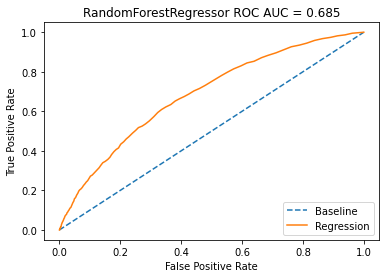

In [11]:
# смотрим ROC AUC
y_pred = model.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('RandomForestRegressor ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [12]:
# точность работы
print(mean_squared_error(y_test, model.predict(X_test)))

0.10779128615932355


In [13]:
# выделяем тестовый датасет из датасета data
data_test = data[data['sample'] == 0]
data_test = data_test.drop(['client_id', 'sample'], axis=1)

Хотел сделать функцию из всей это байды, но не получилось, поэтому просто скопирую весь код.

In [14]:
# у нас всего один год и четыре уникальных месяца, но мы должны написать такой код, 
# что любые даты в формате датасета могли быть верно преобразованны

dict_date = {'JAN':'01','FEB':'02','MAR':'03','APR':'04','MAY':'05','JUN':'06',\
             'JUL':'07','AVG':'08','SEP':'09','OCT':'10','NOV':'11','DEC':'12'}
iterator = 0
for x in data_test['app_date']:
    data_test['app_date'].iloc[iterator] = int(str(data_test['app_date'].iloc[iterator][5:9]) \
                                           + str(dict_date[data_test['app_date'].iloc[iterator][2:5]]) \
                                           + str(data_test['app_date'].iloc[iterator][0:2]))
    iterator += 1
    
# а теперь переведем наши даты из восьмизначных к трезначным - так чтобы дни шли от единицы и дальше
# создаем словарь дата - число
iterator = 0
dict_day = {}
for i in np.sort(data_test['app_date'].unique()):
    dict_day.setdefault(i, iterator+1)
    iterator += 1

# применяем данные к столбцу
iterator = 0
for x in data_test['app_date']:    
    data_test['app_date'].iloc[iterator] = dict_day[data_test['app_date'].iloc[iterator]]
    iterator += 1

# переводим признак education в числовой и заполняем пропуски нолями, так как ноль соответствует самому популярному значению - SCH.
dct_education = {'SCH': 1, 'GRD': 2, 'UGR': 3, 'PGR': 4, 'ACD': 5}
data_test['education'] = data_test['education'].map(dct_education)
data_test['education'] = data_test['education'].fillna(1) # заполняем пропущенные занчения самым популярным значением SCH

# делаем дамми-признаки с признаком sex и work_address
oe_style = OneHotEncoder()
oe_results = oe_style.fit_transform(data_test[["sex"]])
data_test = data_test.join(pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_))

oe_style = OneHotEncoder()
oe_results = oe_style.fit_transform(data_test[["work_address"]])
data_test = data_test.join(pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_))

# удаляем не рабочие признаки и переименовуем для удобства столбцы
data_test = data_test.drop(['car','sex','car_type', 'good_work', 'foreign_passport', 'work_address'], axis=1)

# логарифмируем признак income
data_test['income'] = np.log(data_test['income']+1)

# создаем признаки - дни недели от признака app_date
data_test['app_date0'] = 0
data_test['app_date1'] = 0
data_test['app_date2'] = 0
data_test['app_date3'] = 0
data_test['app_date4'] = 0
data_test['app_date5'] = 0
data_test['app_date6'] = 0
iterator = 0
for x in data_test['app_date']:
    day = x % 7
    data_test['app_date' + str(day)].iloc[iterator] = 1
    iterator += 1

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [15]:
# обучаем модель
X = data_test.dropna().drop(['default'], axis=1)
y_pred = model.predict(X)

In [16]:
# создаем новый датасет
submit = pd.DataFrame(test.client_id)
submit['default'] = y_pred

In [17]:
# выгружаем данные
submit.to_csv('submission.csv', index=False)

In [ ]:
submit